# upsampling 결과로 늘어난 annotation의 dimension 줄이기
- upsampling 결과로 annotation, 즉 masking image가 크기가 커지면서 보간법으로 픽셀을 채워지다보니 0~255 사이의 3채널이 됨. 
- 모델에 넣기 위해서 다시 0, 1로 구성된 segmentation map으로 만들어야 하는 상황임. 

## upsampling된 masking image 확인

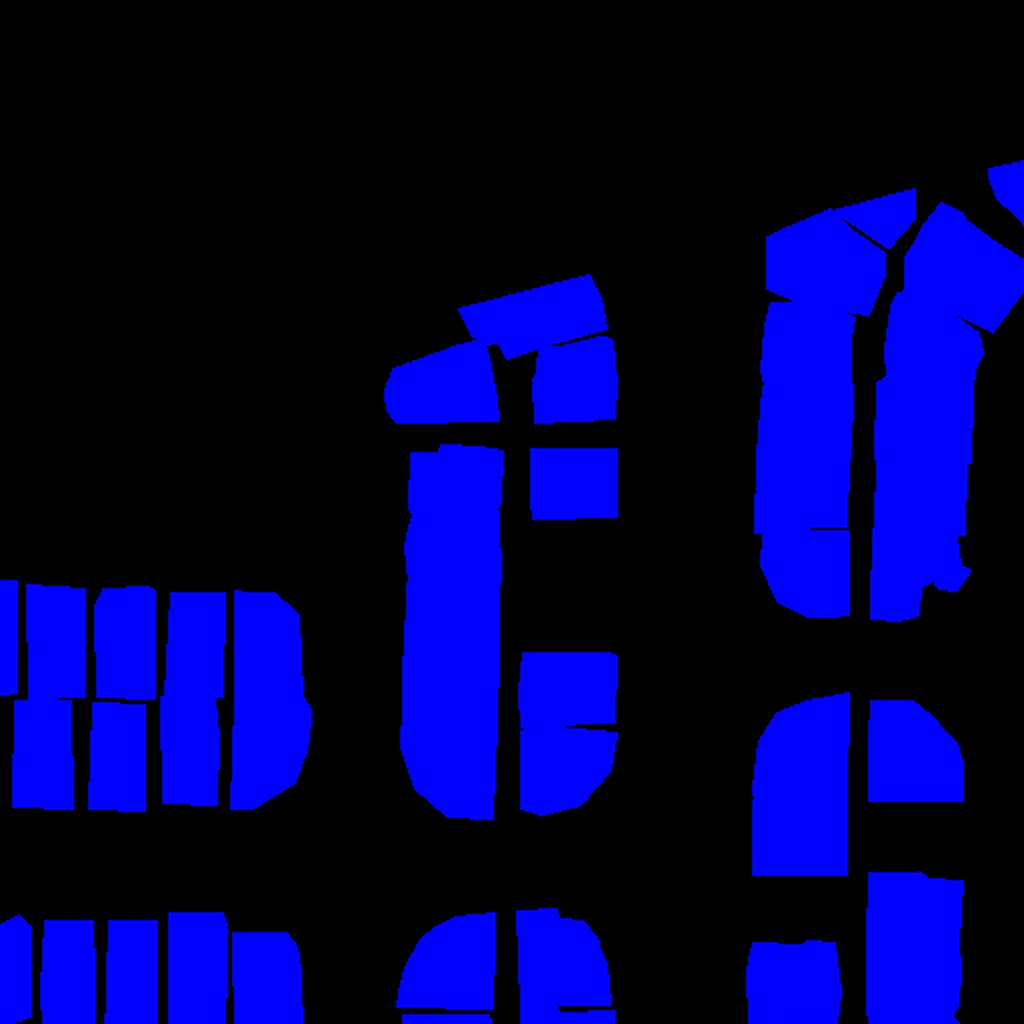

In [ ]:
import cv2
import numpy as np
from PIL import Image
from google.colab.patches import cv2_imshow

img_path = '/content/drive/Shareddrives/msmg/level1/upsampling/croped/train/building/annotation/BLD00001_PS3_K3A_NIA0276_x2_00.png'
img = cv2.imread(img_path)

cv2_imshow(img)

- 확대해보면 검은색과 파란색의 경계가 검은색과 파란색 사이의 여러 색으로 보간되어 있음.

## masking image 이진화

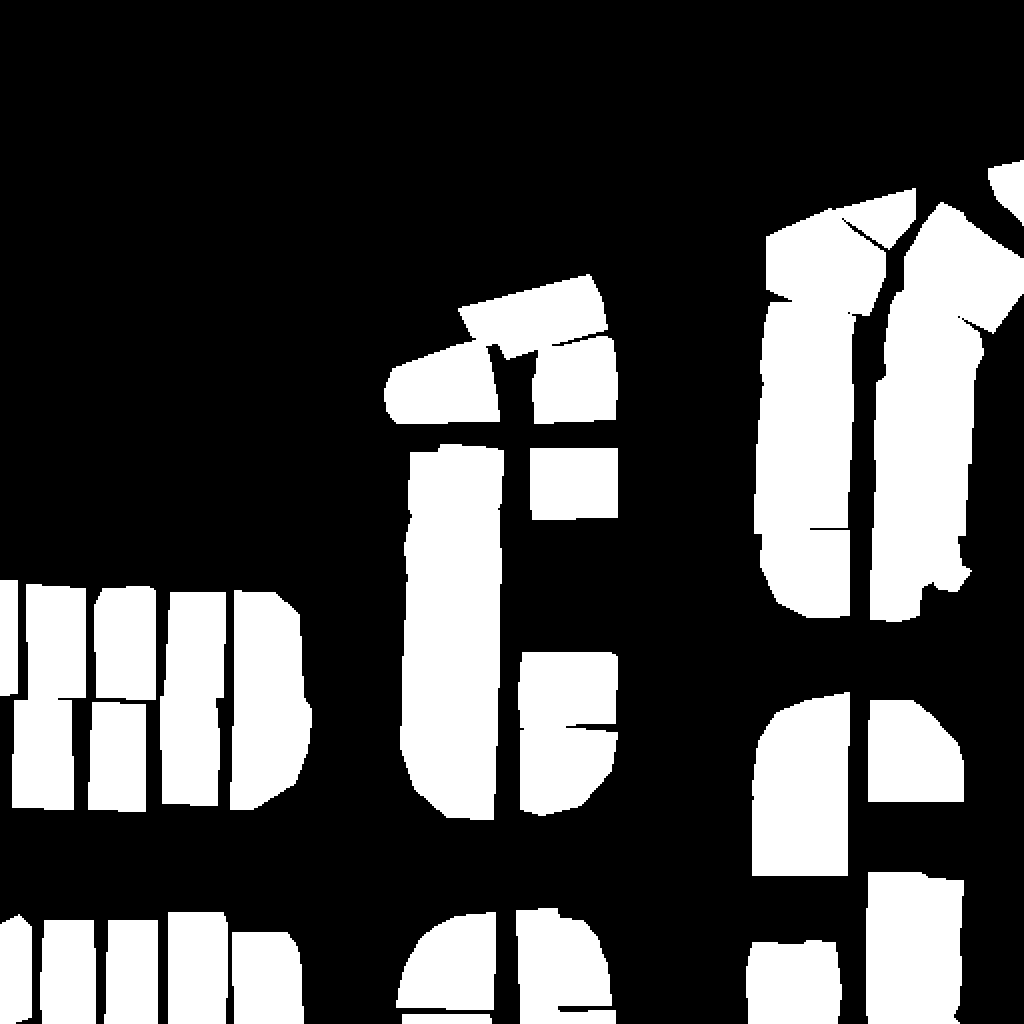

In [ ]:
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, dst = cv2.threshold(grey, 127, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

cv2_imshow(dst)

- cv2의 THRESH_BINARY와 THRESH_OTSU로 image를 127을 기준으로 작으면 0, 크면 255로 이진화함. 

In [ ]:
pixel = np.array(dst)
pixel

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

- np.array로 변환

In [ ]:
pixel[pixel > 1] = 1
pixel

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=uint8)

- palette와 class를 맞추기 위한 pixel 값 정규화

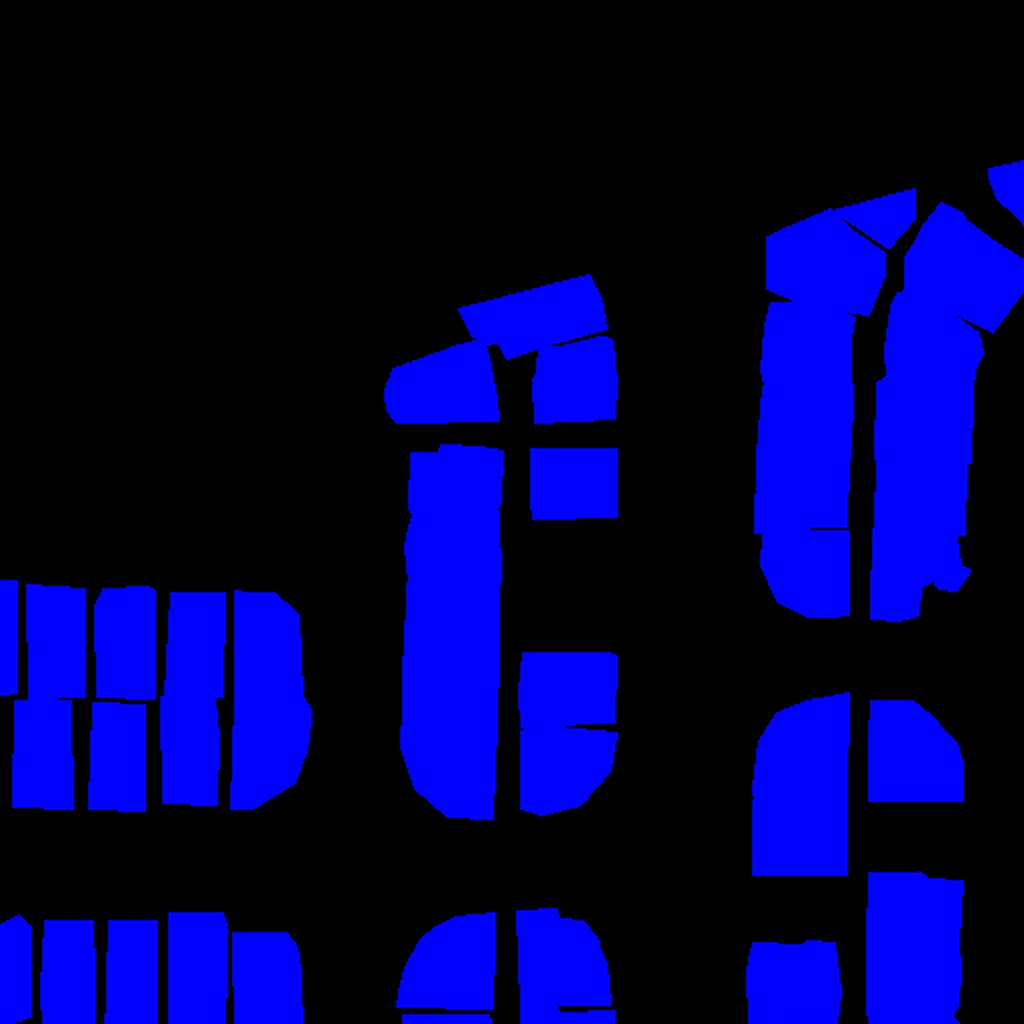

In [ ]:
classes = ('background', 'building')
palette = [[0, 0, 0], [0, 0, 255]]

seg_img = Image.fromarray(pixel).convert('P')
seg_img.putpalette(np.array(palette, dtype=np.uint8))
seg_img.save('/content/seg_img.png')

result_path = '/content/drive/Shareddrives/msmg/level1/upsampling/croped/train/building/annotation/BLD00001_PS3_K3A_NIA0276_x2_00.png'
result = cv2.imread(result_path)
cv2_imshow(result)

- 원래의 annotation, 즉 masking image처럼 변환되었음. 
- 위의 코드들을 함수화해 모든 upsampled annotation에 적용해야 함. 

## 함수화 (dimension_reduction)

- dimension_reduction(img_dir, save_dir, palette)
    - img_dir로부터 image를 읽어서 이진화, pixel 정규화
    - pixel 정규화된 numpy 배열에 palette 적용해 save_dir에 저장

In [ ]:
def dimension_reduction(img_dir, save_dir, palette):
    for img_file in img_dir:

        file_dir, file_name = os.path.split(img_file)
        
        img = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB)
        grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, dst = cv2.threshold(grey, 127, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        pixel = np.array(dst)
        pixel[pixel > 1] = 1

        seg_img = Image.fromarray(pixel).convert('P')
        seg_img.putpalette(np.array(palette, dtype=np.uint8))
        seg_img.save(os.path.join(save_dir, file_name))

In [ ]:
import os
import glob
import cv2
import numpy as np
from PIL import Image

# classes = ('background', 'building')
# classes = ('background', 'road')
palette = [[0, 0, 0], [0, 0, 255]]

dir_upsampled_annotation = sorted(glob.glob('/content/drive/Shareddrives/msmg/level1/upsampling/croped/train/road/annotation/*.png'))
dir_save = '/content/drive/Shareddrives/msmg/level1/upsampling/croped/train/road/reduced_annotation/'

dimension_reduction(dir_upsampled_annotation, dir_save, palette)